In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from bresenham import bresenham

from IPython.display import Image
import time
from tqdm import tqdm_notebook as tqdm

%matplotlib inline

In [28]:
def reader(filename):
    """
    Чтение файлов установленного формата из Arcgis
    """
    df = pd.read_excel(filename, index_col='FID')
    df.columns = map(str.lower, df.columns)
    return df

In [ ]:
def df_encoder():
    """
    Выделение особенностей сегментов в отдельные признаки
    """
    df['wood'] = df['natural'].apply(lambda x: 1 if x=='wood' or x=='forest' else 0)
    df['water'] = df['natural'].apply(lambda x: 1 if x=='water' else 0)
    df['road'] = df['natural'].apply(lambda x: 1 if x=='road' else 0)
    df['building'] = df['building'].apply(lambda x: 1 if x=='road' else 0)
    df.drop('natural', inplace=True)
    return df

In [ ]:
def pos_tager(df):
    """
    Присваивание позиции каждому сегменту
    """
    n = int(df.shape[0]**0.5)
    pos_list = []
    for i in range(n):
        for j in range(n):
            pos_list.append((i, j))
    df['pos'] = pos_list

In [4]:
def circles(x0,y0,x1,y1,min_dist,max_dist):
    """
    Вычисление гипотенузы по позиции сегментов.
    min_dist, max_dist - радиусы, записанные в кол-ве квадратов.
    То есть если нужен круг 1000 метров, а сетка по 25 метров, 
    то, например, max_dist = 1000/25 = 40 
    """
    hypo = (abs(x1-x0)**2 + abs(y1-y0)**2)**0.5
    
    if hypo >= min_dist and hypo <= max_dist:
        return True
    else:
        return False
    
    return hypo

In [ ]:
def ring(all_points, target, min_dist, max_dist):
    """
    Находит квадраты, входящие в "бублик"
    """
    ring_points = []
    for point in all_points:
        if circles(target[0], target[1], point[0], point[1], min_dist, max_dist):
            ring_points.append(point)
    return ring_points

In [ ]:
def modified_bresenham(x0, y0, x1, y1):
    """
    Возвращает список, а не итератор 
    и удаляет первую и последнюю точки
    (т.е. собственные координаты)
    """
    coords = list(bresenham(x0, y0, x1, y1))
    return list(set(coords[1:-1]))

In [5]:
def extended_bresenham(x0, y0, x1, y1, pos_var=0, target_var=0):
    """
    Варьирует строгость позиции и/или 
    строгость места цели
    """
    coords = list(bresenham(x0, y0, x1, y1))
    
    if pos_var > 0:
    
        for var in range(0, pos_var + 1):
            coords.extend(list(modified_bresenham(x0 - var, y0, x1, y1)))
            coords.extend(list(modified_bresenham(x0+var, y0, x1, y1)))
            coords.extend(list(modified_bresenham(x0, y0 + var, x1, y1)))
            coords.extend(list(modified_bresenham(x0, y0 - var, x1, y1)))
    
    if target_var > 0:
    
        for var in range(0, target_var + 1):
            coords.extend(list(modified_bresenham(x0, y0, x1 - var, y1)))
            coords.extend(list(modified_bresenham(x0, y0, x1 + var, y1)))
            coords.extend(list(modified_bresenham(x0, y0, x1, y1 - var)))
            coords.extend(list(modified_bresenham(x0, y0, x1, y1 + var)))
    
    
    coords = sorted([i for i in set(coords) if 
                           i[0] > 0
                           and i[1] > 0 
                           and (i[0]!=x0 and i[1]!=y0) 
                           and (i[0]!=x1 and i[1]!=y1)
                  ])

    return coords

In [39]:
def wood_border(df, target, bound=0):
    """
    Находит границы леса, из которых видна цель.
    Bound - регулирует строгость или "проницаемость".
    Чем больше bound, тем "глубже видим из леса".
    """
    tmp_df = df[['pos', 'wood']]
    wood_border_coords = []
    for i in tqdm(tmp_df.values):
        if i[1] == 1:
            if len(df[df['pos'].isin(modified_bresenham(i[0][0], i[0][1], 
                                                        target[0], target[1]))].query('wood==1')) > bound:
                continue
            else:
                wood_border_coords.append(i[0])
            
    return wood_border_coords       

In [ ]:
def plotter(df, map_shape):
    
    heights = np.array(df['gridcode']).reshape(n,n)
    visibility = np.array(df['visibility']).reshape(n,n)
    wood = np.array(df['wood']).reshape(n,n).reshape(n,n)
    water = np.array(df['water']).reshape(n,n).reshape(n,n)
    road = np.array(df['road']).reshape(n,n)
    building = np.array(df['building']).reshape(n,n)
    
    wb = wood_border(df, (map_shape,map_shape))
    bp = ring(all_points=df['pos'], target=(map_shape,map_shape), min_dist=10, max_dist=40)
    #map_shape=125!
    
    
    

In [ ]:
Image("MO.png")

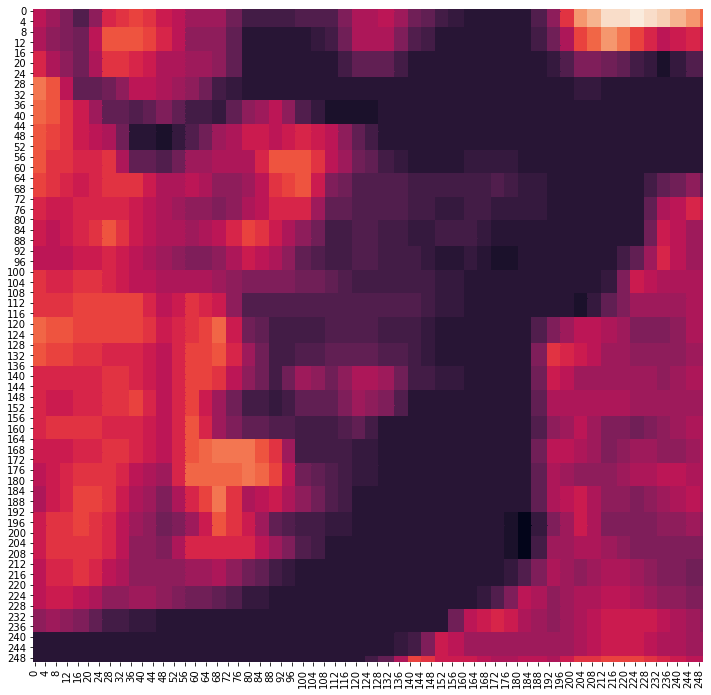

In [9]:
plt.figure(figsize=(12,12))
sns.heatmap(heights, alpha=1, cbar=False);

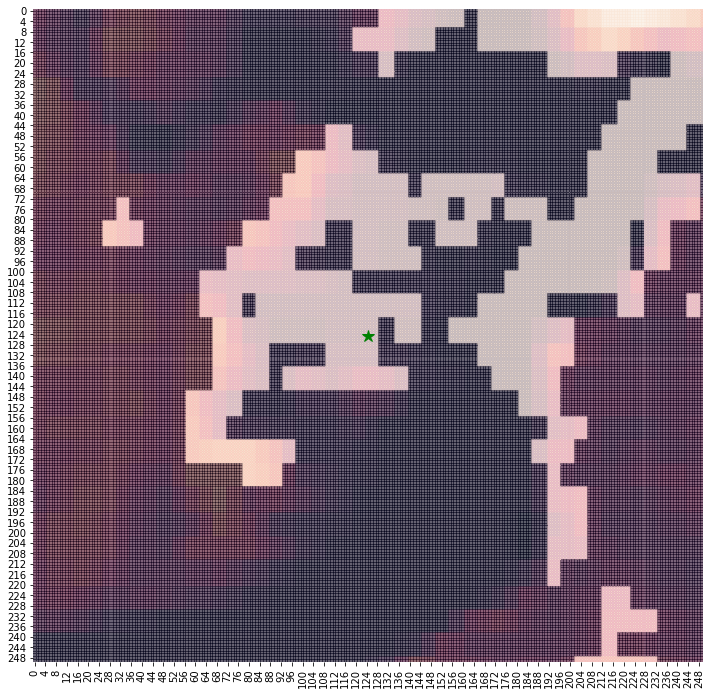

In [11]:
plt.figure(figsize=(12,12))
sns.heatmap(heights, alpha=0.4, cbar=False);
sns.heatmap(visibility, alpha=0.4, cbar=False);
plt.plot(n/2, n/2, color='green', marker='*', linestyle='dashed', linewidth=2, markersize=12);

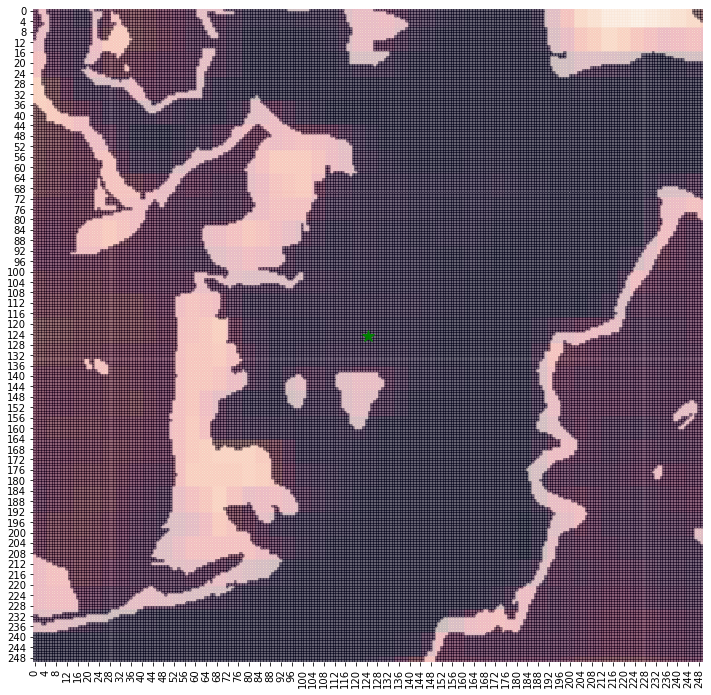

In [41]:
df['wood'] = df['natural'].apply(lambda x: 1 if x=='wood' else 0)
wood = np.array(df['wood']).reshape(n,n)

plt.figure(figsize=(12,12))
sns.heatmap(heights, alpha=0.4, cbar=False);
sns.heatmap(wood, alpha=0.4, cbar=False);
plt.plot(n/2, n/2, color='green', marker='*', linestyle='dashed', linewidth=2, markersize=12);

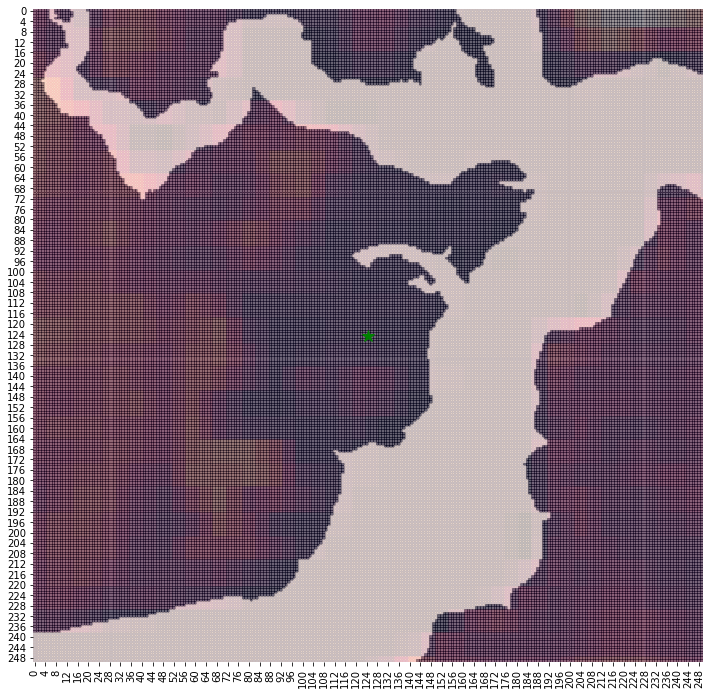

In [13]:
df['water'] = df['natural'].apply(lambda x: 1 if x=='water' else 0)
water = np.array(df['water']).reshape(n,n)

plt.figure(figsize=(12,12))
sns.heatmap(heights, alpha=0.4, cbar=False);
sns.heatmap(water, alpha=0.4, cbar=False);
plt.plot(n/2, n/2, color='green', marker='*', linestyle='dashed', linewidth=2, markersize=12);

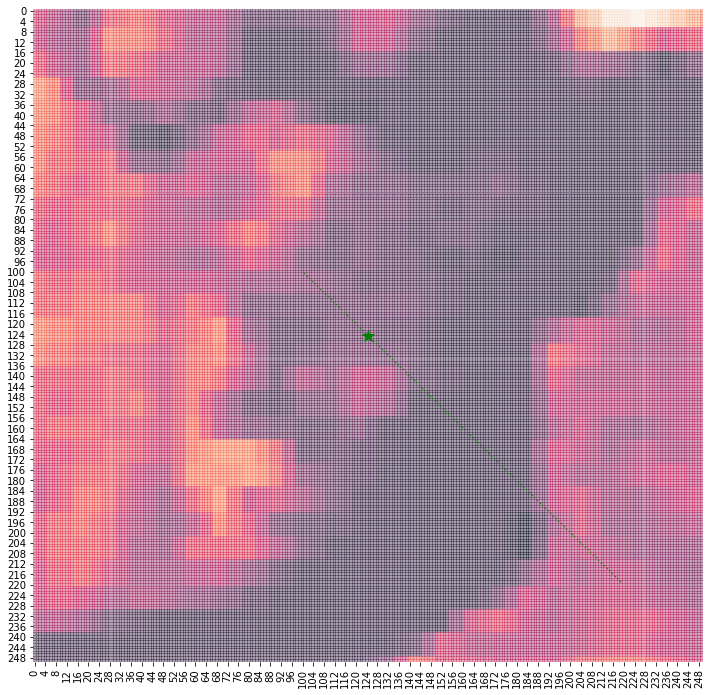

In [14]:
plt.figure(figsize=(12,12))
sns.heatmap(heights, alpha=0.4, cbar=False);
#plt.plot(list(bresenham(100, 100, 120, 120)))
plt.plot(n/2, n/2, color='green', marker='*', linestyle='dashed', linewidth=2, markersize=12);
for i in list(modified_bresenham(100, 100, 220, 220)):
    plt.plot(i[0], i[1], color='green', marker='.', linestyle='dashed', linewidth=2, markersize=1);

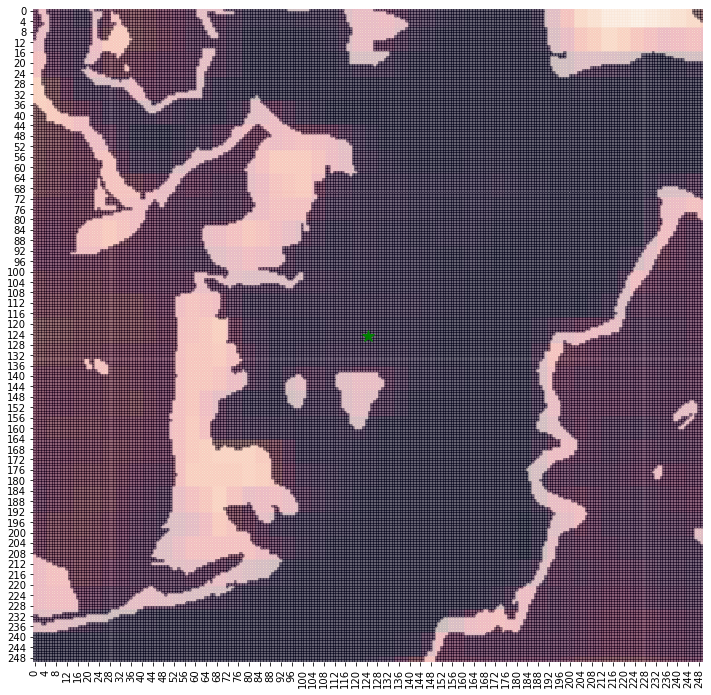

In [15]:
df['wood'] = df['natural'].apply(lambda x: 1 if x=='wood' else 0)
wood = np.array(df['wood']).reshape(n,n)

plt.figure(figsize=(12,12))
sns.heatmap(heights, alpha=0.4, cbar=False);
sns.heatmap(wood, alpha=0.4, cbar=False);
plt.plot(n/2, n/2, color='green', marker='*', linestyle='dashed', linewidth=2, markersize=12);

In [16]:
%%time
def wood_border(df, target):
    tmp_df = df[['pos', 'wood']]
    wood_border_coords = []
    for i in tqdm(tmp_df.values):
        if i[1] == 1:
            if len(df[df['pos'].isin(modified_bresenham(i[0][0], i[0][1], 
                                                        target[0], target[1]))].query('wood==1')) > 0:
                continue
            else:
                wood_border_coords.append(i[0])
            
    return wood_border_coords       

                
x = wood_border(df, (125,125))

<timed exec>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



CPU times: user 53 s, sys: 827 ms, total: 53.8 s
Wall time: 53.4 s


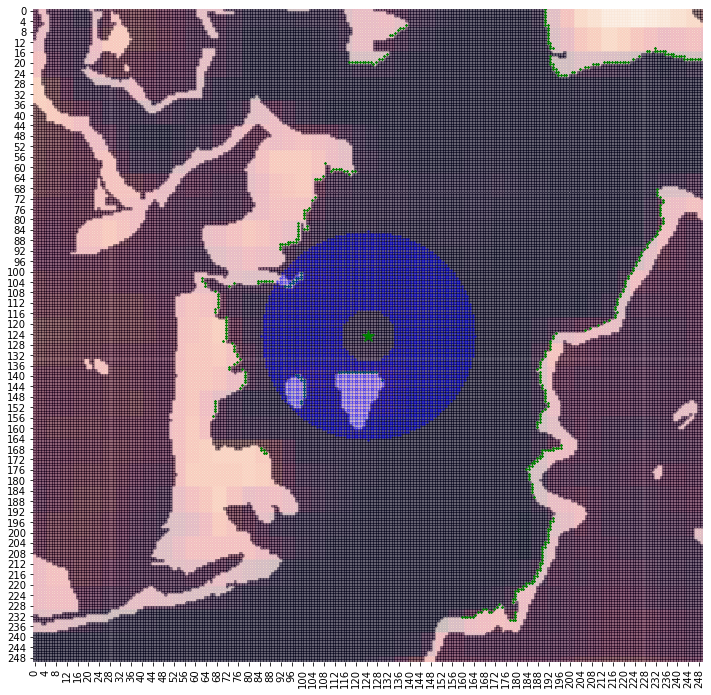

In [17]:
df['wood'] = df['natural'].apply(lambda x: 1 if x=='wood' else 0)
wood = np.array(df['wood']).reshape(n,n)

plt.figure(figsize=(12,12))
sns.heatmap(heights, alpha=0.4, cbar=False);
sns.heatmap(wood, alpha=0.4, cbar=False);
plt.plot(n/2, n/2, color='green', marker='*', linestyle='dashed', linewidth=2, markersize=12);

for i in x:
    plt.plot(i[1], i[0], color='green', marker='*', linestyle='dashed', linewidth=2, markersize=2);
    
for i in bp:
    plt.plot(i[1], i[0], color='blue', marker='*', linestyle='dashed', linewidth=2, markersize=2, alpha=0.4);

In [18]:
import pickle

In [19]:
with open('data_converted/DJI_0060.pkl', 'rb') as f:
    data = pickle.load(f)

In [20]:
data

array([[[ 1.        , 55.26068523, 37.83937206],
        [ 0.        , 55.26077495, 37.83936766],
        [ 0.        , 55.26086467, 37.83936326],
        [ 0.        , 55.26095439, 37.83935887],
        [ 0.        , 55.26104412, 37.83935447],
        [ 0.        , 55.26113384, 37.83935007],
        [ 1.        , 55.26122356, 37.83934567],
        [ 0.        , 55.26131329, 37.83934127],
        [ 0.        , 55.26140301, 37.83933688],
        [ 1.        , 55.26149273, 37.83933248],
        [ 0.        , 55.26158246, 37.83932808],
        [ 0.        , 55.26167218, 37.83932368],
        [ 0.        , 55.2617619 , 37.83931928],
        [ 0.        , 55.26185162, 37.83931488],
        [ 0.        , 55.26194135, 37.83931049],
        [ 0.        , 55.26203107, 37.83930609],
        [ 1.        , 55.26212079, 37.83930169],
        [ 1.        , 55.26221052, 37.83929729],
        [ 0.        , 55.26230024, 37.83929289]],

       [[ 0.        , 55.26068272, 37.83921461],
        [ 0.      

In [31]:
df1 = reader('new/Vlad_1_new.xls')
df2 = reader('new/Vlad_2_new.xls')
df3 = reader('new/Vlad_3.xls')
df4 = reader('new/Vlad_4.xls')

In [34]:
df1['natural'].unique()

array(['forest', ' ', 'road', 'water', 'building'], dtype=object)

In [35]:
df2['natural'].unique()

array(['forest', ' ', 'road', 'water'], dtype=object)

In [36]:
df3['natural'].unique()

array(['forest', 'road', ' ', 'water', 'building'], dtype=object)

In [37]:
df4['natural'].unique()

array(['forest', 'road', ' ', 'building'], dtype=object)